Microsoft Differential Privacy Whitepaper Collateral Notebooks Part 5
# Using SmartNoise to create synthetic data with high utility for machine learning

<img src="images/synthetic.jpg" width=1000 />
This notebook demonstrates how to use  SmartNoise to create a synthetic dataset, which can then be used to achieve comparable performance to other differentially private options for machine learning.
The essential advantage of the synthesizer approach is that the differentially private dataset can be analyzed any number of times without increasing the privacy risk. Therefore, it enables collaboration between several parties, democratizing knowledge, or open dataset initiatives.
In the following, we use a the Quail-ified Architecture to Improve Learning (QUAIL) that improves the utility of synthetic differentially private datasets specifically for machine learning tasks.

## Setup
### Installs and imports

In [1]:
# !pip install smartnoise-synth opendp

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

## Generate dataset for supervised classification
We are using the `make_classification` function from Scikit Learn to generate a  dataset as starting point. While it is not a real world dataset, the approach has the advantage that the characteristics of the data (e.g. number of features, classes, noise, amount of mislabeled instances and classification dificulty) can be controlled.

Our dataset has the following characteristics:

- 100,000 instances, 10 classes
- 7 features
- 3% of instances are mislabeled

In [3]:
n_samples = 100000
n_features = 7
n_informative = 7 # relevant features to explain target
n_redundant = 0 # linear combinations of informative
n_repeated = 0 # random copies of informative and redundant
n_useless = n_features - n_informative - n_redundant - n_repeated # noise

n_classes = 10
seed = 1

In [4]:
# define feature names
def feature_names (n_items, prefix = 'feature'):
    names = []
    for i in range(n_items):
        names.append(prefix + '_' + str(i))
    return names

inf_features = feature_names(n_informative, 'inf')
red_features = feature_names(n_redundant, 'red')
rep_features = feature_names(n_repeated, 'rep')
useless_features = feature_names(n_useless, 'noise')

feature_names = inf_features + red_features + rep_features + useless_features

X, y = make_classification(n_samples=n_samples, 
                    n_features=n_features, 
                    n_informative=n_informative, 
                    n_redundant=n_redundant, 
                    n_repeated=n_repeated, 
                    n_classes=n_classes, 
                    n_clusters_per_class=2, 
                    weights=None, 
                    flip_y=0.03, 
                    class_sep=5.0, 
                    hypercube=True, 
                    shift=15.0,
                    scale=0.5,
                    shuffle=False, 
                    random_state=seed)

### Convert classes to integer values


In [5]:
# Convert to Dataframe
Z=np.zeros((X.shape[0], X.shape[1]+1))
Z[:,:-1]=X
Z[:,-1]=y

columns = feature_names + ['class']
df = pd.DataFrame(Z, columns=columns)
df['class'] = df['class'].astype('int32')

df.head()

inf_0      inf_1      inf_2      inf_3     inf_4     inf_5      inf_6  \
0   9.622483  10.776050   9.671523   9.976871  4.844616  4.195274   9.181214   
1   8.758071  12.884599  10.786024  10.314471  5.946004  5.579375   9.461131   
2  10.950740   9.837627  10.308713   9.139833  5.224695  5.835789  10.724998   
3  10.208986   9.960696   9.952239  10.574564  5.025228  4.649186  10.239452   
4   8.706916   9.653345   9.507716  10.181471  4.246708  4.525342   8.781617   

   class  
0      0  
1      0  
2      0  
3      0  
4      0

### Review pairs of selected features for an intuition of the classification difficulty

<Figure size 432x288 with 0 Axes>

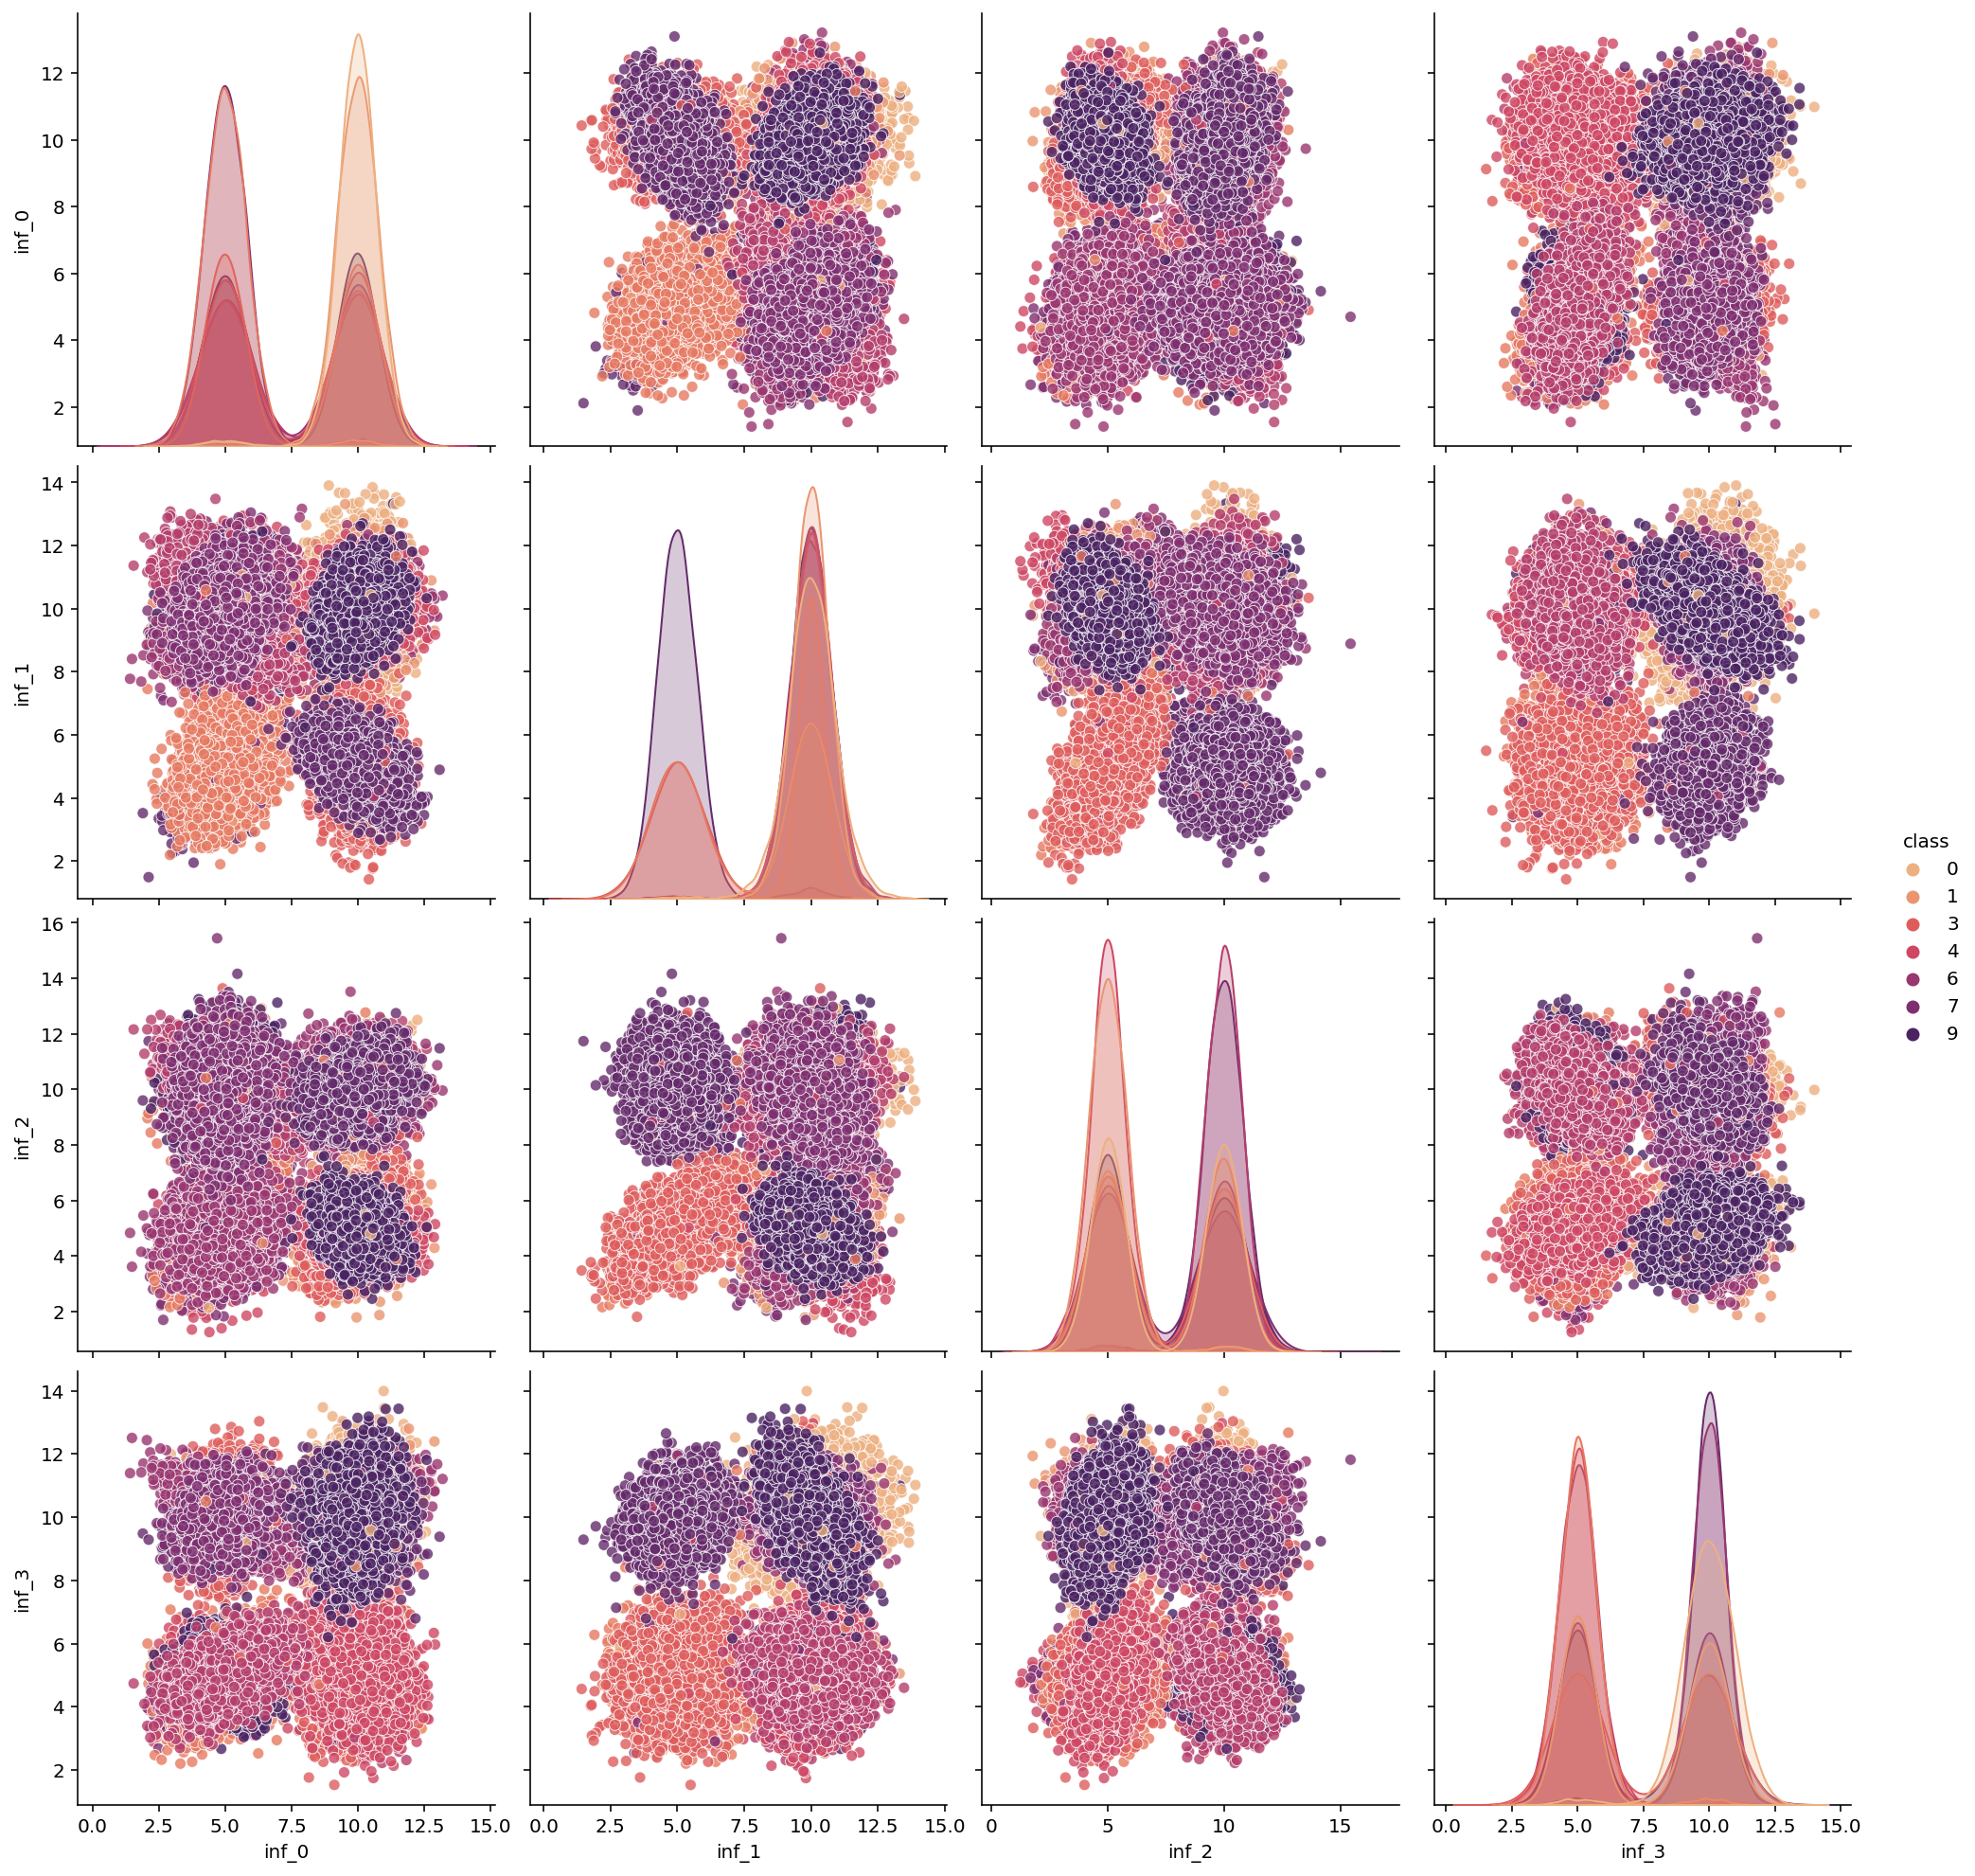

In [6]:
plot_features = inf_features[:4]

plt.clf()
g = sns.pairplot(df, vars=plot_features, height=3.5, hue='class', plot_kws=dict(alpha=0.8), palette='flare')
plt.show()

In [7]:
Xy_train, Xy_test = train_test_split(df, test_size=0.2, stratify = df['class'], random_state = seed)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

Xy_train.loc[:,inf_features] = scaler.fit_transform(Xy_train.loc[:,inf_features])
Xy_test.loc[:,inf_features] = scaler.transform(Xy_test.loc[:,inf_features])

In [9]:
X_train = Xy_train.drop('class', axis=1)
y_train = Xy_train['class']

X_test = Xy_test.drop('class', axis=1)
y_test = Xy_test['class']

## Train non-private and differentially private models for comparison
We are training the following benchmark models on the original dataset for comparison with the results of the synthesizer approach:
- __Non-private model__: Non-private Random Forest classifier to validate upper bound of achievable accuracy (97% expected based on the dataset)
- __Differentially private models__: Differentially private versions of Logistic Regression and the Naïve Bayes algorithm from the diffprivlib library (epsilon of 3.0). 

### Non-private Random Forest classifier

In [10]:
np.random.seed(seed)

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=seed)
clf.fit(X_train, y_train)    

def evaluate (clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    y_probs = clf.predict_proba(X_test)
    roc_score = roc_auc_score(y_test, y_probs, multi_class='ovo')
    print('ROC AUC Score: %f' %roc_score)
    
evaluate(clf, X_test, y_test)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2006
           1       0.97      0.98      0.97      1998
           2       0.97      0.96      0.97      2001
           3       0.97      0.97      0.97      1993
           4       0.98      0.97      0.97      2000
           5       0.97      0.98      0.97      2003
           6       0.97      0.98      0.97      1988
           7       0.97      0.97      0.97      2006
           8       0.97      0.97      0.97      2006
           9       0.97      0.97      0.97      1999

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

ROC AUC Score: 0.984251


### Differentially private Logistic Regression
Before fitting the Logistic regression classifier, we standardize the feature variables using StandardScaler.

In [11]:
from diffprivlib.models import LogisticRegression as DPLR

clf = DPLR(epsilon=3.0, data_norm=5.026)
clf.fit(X_train, y_train)

evaluate(clf, X_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2006
           1       0.84      0.90      0.87      1998
           2       0.96      0.94      0.95      2001
           3       0.76      0.83      0.79      1993
           4       0.93      0.84      0.88      2000
           5       0.89      0.95      0.92      2003
           6       0.81      0.86      0.83      1988
           7       0.91      0.95      0.93      2006
           8       0.97      0.96      0.97      2006
           9       0.82      0.68      0.75      1999

    accuracy                           0.88     20000
   macro avg       0.89      0.88      0.88     20000
weighted avg       0.89      0.88      0.88     20000

ROC AUC Score: 0.977481


### Differentially private Naive Bayes

In [12]:
from diffprivlib.models import GaussianNB as DPNB

# Required parameters for DP version of Gaussian Naive Bayes
lower = list(X_train.min())
upper = list(X_train.max())
bounds = (lower, upper)

clf = DPNB(epsilon=3.0, bounds=bounds)
clf.fit(X_train, y_train)

evaluate(clf, X_test, y_test)

              precision    recall  f1-score   support

           0       0.66      0.94      0.77      2006
           1       0.32      0.15      0.21      1998
           2       0.97      0.96      0.97      2001
           3       0.92      0.97      0.94      1993
           4       0.64      0.72      0.68      2000
           5       0.97      0.96      0.96      2003
           6       0.69      0.95      0.80      1988
           7       0.65      0.95      0.77      2006
           8       0.97      0.97      0.97      2006
           9       0.46      0.03      0.06      1999

    accuracy                           0.76     20000
   macro avg       0.72      0.76      0.71     20000
weighted avg       0.72      0.76      0.71     20000

ROC AUC Score: 0.962462


## Synthesize dataset with differential privacy using the QUAIL method

In [13]:
Xy_train.head()

inf_0     inf_1     inf_2     inf_3     inf_4     inf_5     inf_6  \
19593 -1.062811  0.289829  1.485568  0.177296 -1.045975 -1.258811 -0.449118   
57406  1.155943  0.672817 -0.521652 -0.984263  1.127483  0.963554  1.319874   
88599 -1.320792  0.184815  0.968994  0.681540 -0.964468  0.686489  1.161721   
51135  0.687193  0.146141 -0.751915  1.014100  1.075303 -1.077278 -0.459374   
96113  0.618073  0.484003 -1.094734  0.767910 -1.055770  0.879046 -0.846655   

       class  
19593      3  
57406      1  
88599      7  
51135      0  
96113      9

We've pioneered a very simple boosting architecture known as QUAIL for scenarios just like this (where we know the ML task, and want to generate synthetic data). 

<img src="images/QUAIL.png" width=700 />

QUAIL (Quailified Architecture to Improve Learning) divides epsilon in a known classification task between a differentially private synthesizer and classifier. It trains the DP classifier on real data to predict the label, fits the DP synthesizer to features (excluding the target label) and uses synthetic data from the DP synthesizer with the DP classifier to create artificial labels. It produces a complete synthetic dataset approaching the accuracy of the original vanilla DP ML model.

In [18]:
%%time

from snsynth.mwem import MWEMSynthesizer
from snsynth.quail import QUAILSynthesizer

from snsynth.pytorch.pytorch_synthesizer import PytorchDPSynthesizer
from snsynth.preprocessors.preprocessing import GeneralTransformer
from snsynth.pytorch.nn.dpctgan import DPCTGAN
from snsynth.pytorch.nn.patectgan import PATECTGAN


def QuailClassifier(epsilon):
            return DPLR(epsilon=epsilon, data_norm=5.02)

def QuailSynth(epsilon):
    return PytorchDPSynthesizer(epsilon, preprocessor=None,
                    gan=PATECTGAN(loss='cross_entropy', batch_size=50, noise_multiplier=5.0))

synth = QUAILSynthesizer(3.0, QuailSynth, QuailClassifier, 'class', eps_split=0.8)
                        
synth.fit(Xy_train)

CPU times: user 4min 5s, sys: 49.7 s, total: 4min 55s
Wall time: 51 s


In [20]:
%%time

sample_size = Xy_train.shape[0]

synthetic = synth.sample(int(sample_size))

# Convert to dataframe
synth_df = pd.DataFrame(synthetic, columns=Xy_train.columns)

CPU times: user 2.25 s, sys: 426 ms, total: 2.68 s
Wall time: 2.26 s


In [21]:
synth_df.head()

inf_0     inf_1     inf_2     inf_3     inf_4     inf_5     inf_6  class
0 -0.202872 -1.206686 -1.225718  0.682724  1.958384 -0.941112  0.951136      8
1  1.397256 -0.903484 -0.931022 -1.117437  1.746661 -1.201583  1.557679      1
2  1.039554 -0.216930 -0.314077 -1.377057  0.622607 -1.382982 -1.249728      5
3 -0.991288 -0.266129 -0.944856  1.029657 -0.868118  0.447125  1.380325      7
4 -1.006429  0.162409 -0.679455 -1.122445 -1.468510  1.877501 -1.115327      9

In [22]:
X_train_dp = synth_df.drop('class', axis = 1)
y_train_dp = synth_df['class']

np.random.seed(seed)

clf = RandomForestClassifier(random_state=seed)
clf.fit(X_train_dp, y_train_dp)

evaluate(clf, X_test, y_test)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2006
           1       0.85      0.92      0.88      1998
           2       0.97      0.96      0.96      2001
           3       0.89      0.88      0.89      1993
           4       0.92      0.92      0.92      2000
           5       0.90      0.96      0.93      2003
           6       0.86      0.87      0.86      1988
           7       0.92      0.92      0.92      2006
           8       0.97      0.97      0.97      2006
           9       0.83      0.72      0.77      1999

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

ROC AUC Score: 0.981654


The results show that performing machine learning based on a differentially private synthetic dataset can lead to comparable performance like a differentially private classifier. However, research shows that this is not always the case depending on the dataset's size and characteristics, and other factors.
The synthesizer approach's main advantage is that the resulting dataset can be shared and used for analytical purposes any number of times without increasing the risk of privacy loss.
Another advantage is that the synthesizer allows producing any arbitrary amount of data derived from the original dataset's distribution. This could be a promising approach for data augmentation to improve the resulting machine learning model's quality.
